# Лабораторная работа №2

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import yfinance as yf

Создадим функцию для скачивания временных рядов

In [2]:
def load_data(tickers, start_date, end_date):
    data = yf.download(tickers,start_date,end_date)
    return data['Close']

Скачаем временной ряд ETH-USD

In [4]:
ETHUSD=load_data('ETH-USD','2021-12-01','2024-12-01')

[*********************100%***********************]  1 of 1 completed


Отобразим временной ряд на графике

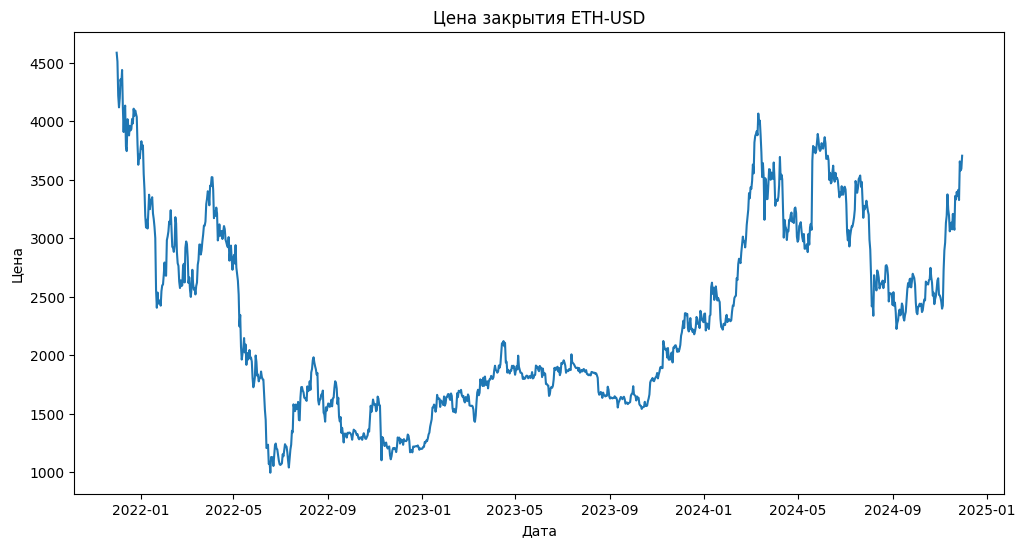

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(ETHUSD)
plt.title('Цена закрытия ETH-USD')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

Проведём декомпозицию временного ряда на тренд, сезонность и остаток и отбразим их на отдельныъ графиках

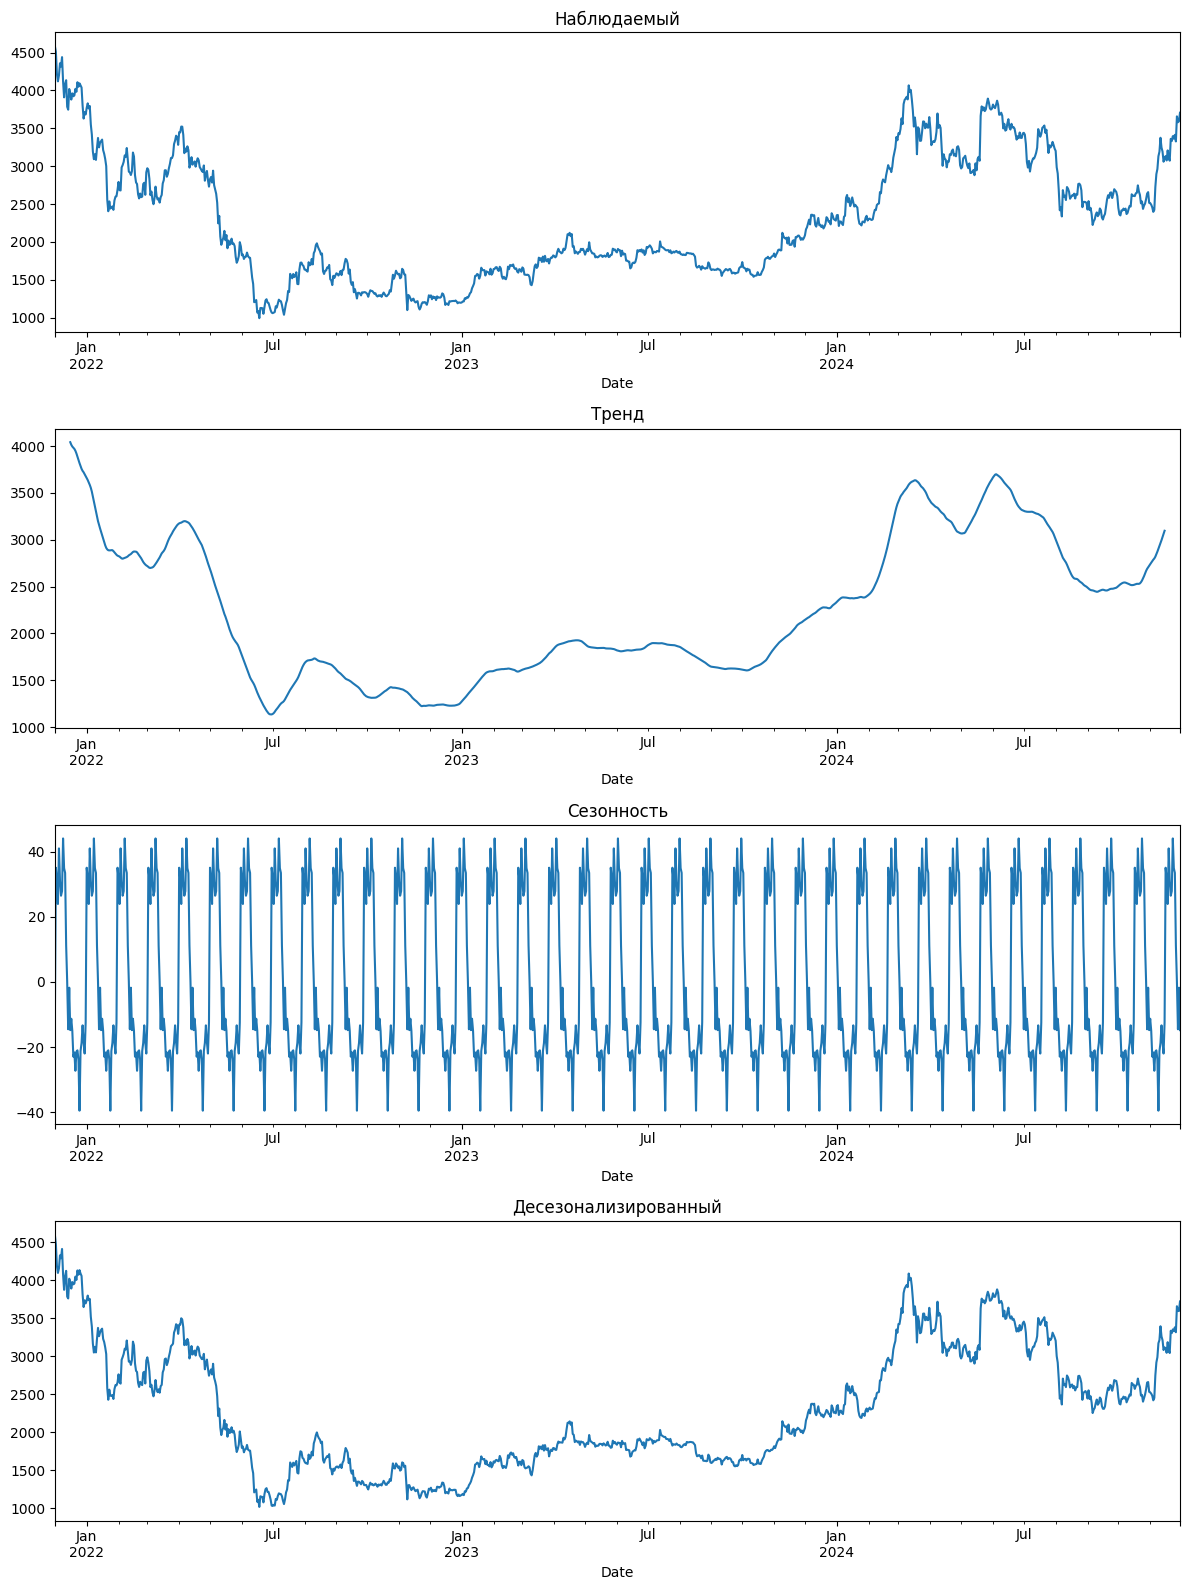

In [6]:
decomposition = seasonal_decompose(ETHUSD, model='additive',period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Наблюдаемый')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Тренд')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Сезонность')
deseasonal = decomposition.observed-decomposition.seasonal
deseasonal.plot(ax=ax4)
ax4.set_title('Десезонализированный')
plt.tight_layout()
plt.show()

После удаления сезонности график немного изменился, однако говорить о серъезных изменениях нельзя, это говорит о том, что сезонность слабо выраженная

In [7]:
def predict_ema(data, periods=5):
    ema = data.ewm(span=30, adjust=False).mean()
    last_ema = ema.iloc[-1]
    
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods)
    
    if len(ema) > 1:
        growth_rate = (ema.iloc[-1] / ema.iloc[-2]) -1
    else:
        growth_rate = 0
    
    future_ema = [last_ema * (1 + growth_rate)**i for i in range(1, periods + 1)]
    
    return future_dates, future_ema

Сделаем прогноз на основе тренда и сезонности

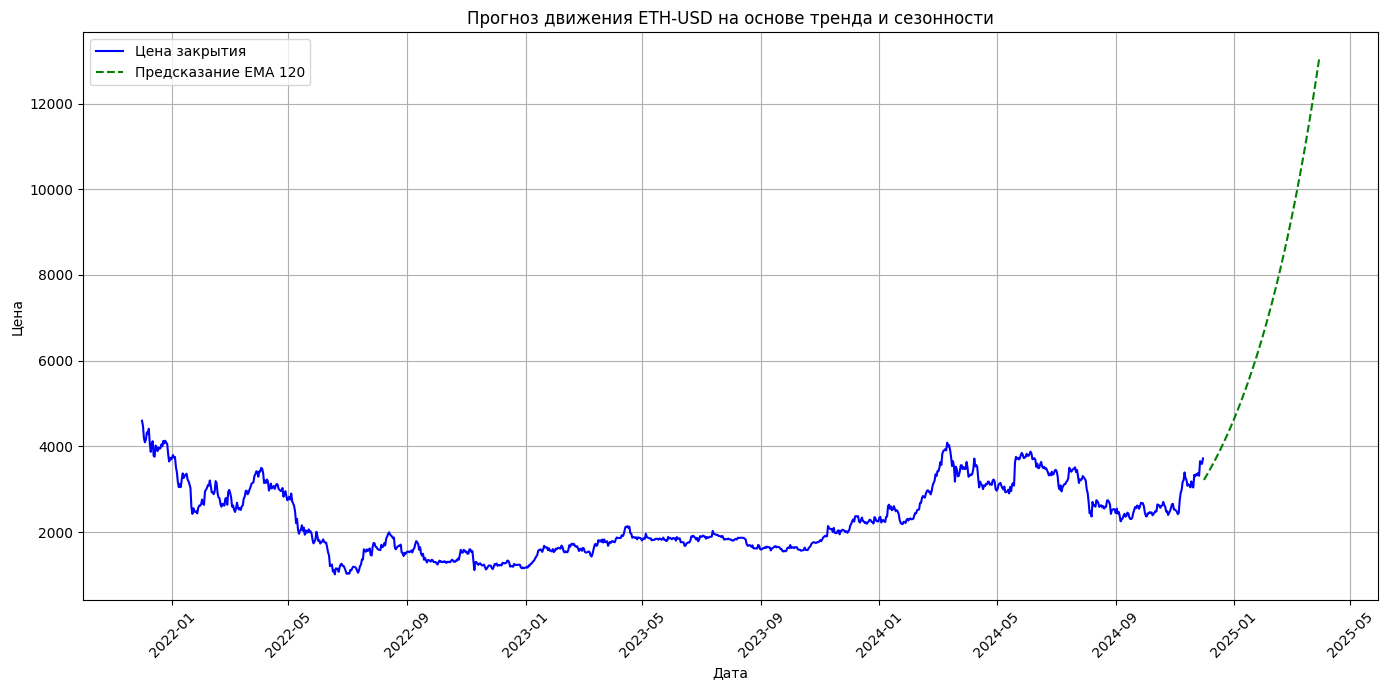

In [8]:
future_dates, future_ema = predict_ema(deseasonal,120)
plt.figure(figsize=(14, 7))
plt.plot(deseasonal.index, deseasonal.values, label='Цена закрытия', color='blue')
plt.plot(future_dates, future_ema, label='Предсказание EMA 120', color='green', linestyle='dashed')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогноз движения ETH-USD на основе тренда и сезонности')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Оценим качество прогноза, используя метрики MAE и RMSE

In [9]:
ETHUSD_future=load_data('ETH-USD','2024-08-03','2024-12-01')
print(ETHUSD_future.size)
mae = mean_absolute_error(ETHUSD_future, future_ema)
rmse = np.sqrt(mean_squared_error(ETHUSD_future, future_ema))

print(f"MAE: {round(mae,2)}, RMSE: {round(rmse,2)}")

[*********************100%***********************]  1 of 1 completed

120
MAE: 4358.32, RMSE: 5072.85


Проведём тест на стационарность

In [10]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

adf_test(ETHUSD)

ADF Statistic: -2.140484812890002
p-value: 0.2285499979757094
Critical Values:
	1%: -3.436352507699052
	5%: -2.86419037625175
	10%: -2.56818114683546


Так как p-value > 0.05, то ряд нестационарный

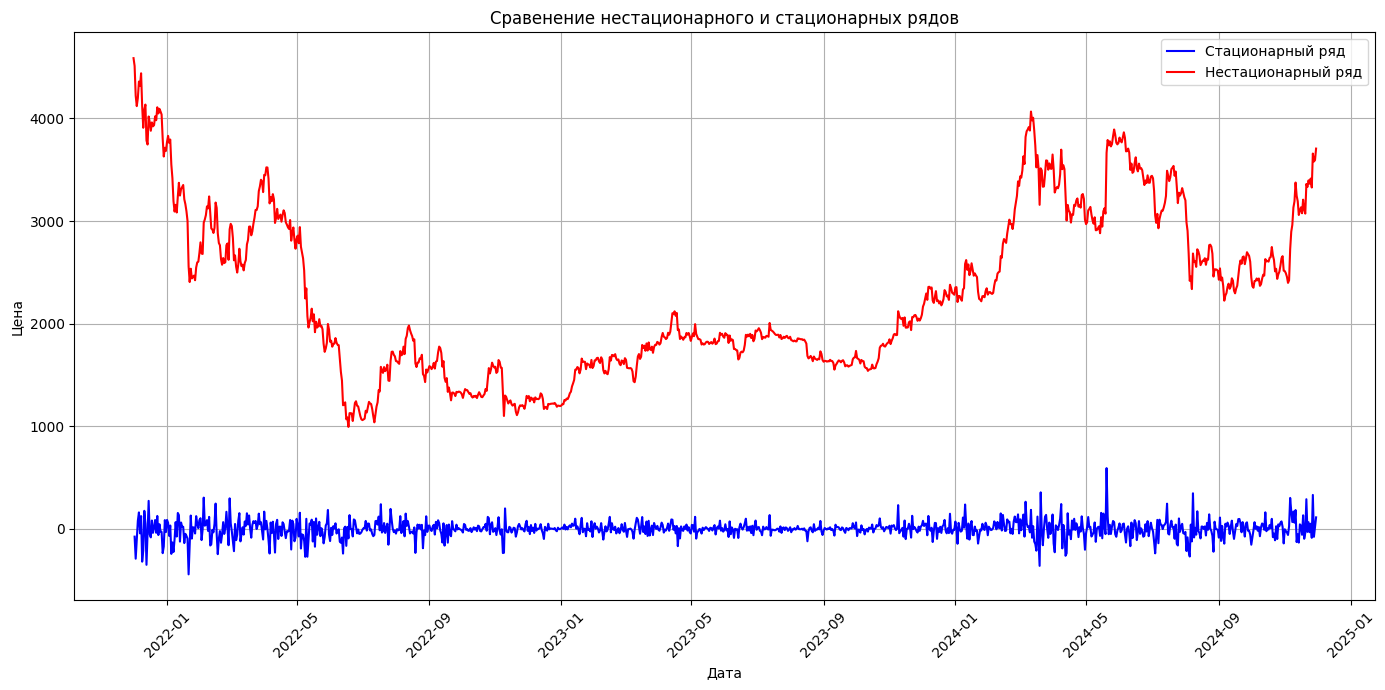

In [11]:
differenced = ETHUSD.diff().dropna()


plt.figure(figsize=(14, 7))
plt.plot(differenced.index, differenced.values, label='Стационарный ряд', color='blue')
plt.plot(ETHUSD.index, ETHUSD.values, label='Нестационарный ряд', color='red')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Сравенение нестационарного и стационарных рядов')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
def evaluate_arima_model(X, arima_order):
    # Разделение на обучающую и тестовую выборки
    train_size = int(len(X) * 0.8)
    train, test = X[:train_size], X[train_size:]
    
    # Обучение модели
    model = ARIMA(train, order=arima_order,trend='ct')
    model_fit = model.fit()
    
    # Прогноз
    forecast = model_fit.forecast(steps=len(test))
    
    # Оценка качества прогноза
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    return mae, rmse

AR Модель

In [13]:
p_values = range(0, 10)
d_values = [0]
q_values = [0]

deseasonal.index = pd.DatetimeIndex(deseasonal.index.values, freq=deseasonal.index.inferred_freq)

best_score_ar, best_cfg_ar = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(deseasonal, order)
                if mae < best_score_ar:
                    best_score_ar, best_cfg_ar = mae, order
                print(f'AR{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель AR{best_cfg_ar} MAE={best_score_ar:.3f}')

AR(0, 0, 0) MAE=990.112 RMSE=1087.900
AR(1, 0, 0) MAE=365.885 RMSE=419.669
AR(2, 0, 0) MAE=366.549 RMSE=419.823
AR(3, 0, 0) MAE=367.228 RMSE=419.488
AR(4, 0, 0) MAE=364.469 RMSE=419.287
AR(5, 0, 0) MAE=363.158 RMSE=419.184
AR(6, 0, 0) MAE=364.064 RMSE=419.300
AR(7, 0, 0) MAE=364.044 RMSE=419.318


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR(8, 0, 0) MAE=363.149 RMSE=419.035
AR(9, 0, 0) MAE=365.400 RMSE=419.237
Лучшая модель AR(8, 0, 0) MAE=363.149


MA модель

In [14]:
p_values = [0]
d_values = [0]
q_values = range(0, 10)

deseasonal.index = pd.DatetimeIndex(deseasonal.index.values, freq=deseasonal.index.inferred_freq)

best_score_ma, best_cfg_ma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(deseasonal, order)
                if mae < best_score_ma:
                    best_score_ma, best_cfg_ma = mae, order
                print(f'MA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель MA{best_cfg_ma} MAE={best_score_ma:.3f}')

MA(0, 0, 0) MAE=990.112 RMSE=1087.900
MA(0, 0, 1) MAE=983.729 RMSE=1082.974
MA(0, 0, 2) MAE=983.227 RMSE=1082.221


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 3) MAE=975.378 RMSE=1076.357


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 4) MAE=972.778 RMSE=1073.907


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 5) MAE=961.665 RMSE=1065.518


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 6) MAE=962.512 RMSE=1065.959


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 7) MAE=444.104 RMSE=508.644


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 8) MAE=951.373 RMSE=1056.840
MA(0, 0, 9) MAE=574.025 RMSE=731.456
Лучшая модель MA(0, 0, 7) MAE=444.104


ARMA модель

In [15]:
p_values = range(0, 5)
d_values = [0]
q_values = range(0, 5)

deseasonal.index = pd.DatetimeIndex(deseasonal.index.values, freq=deseasonal.index.inferred_freq)

best_score_arma, best_cfg_arma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(deseasonal, order)
                if mae < best_score_arma:
                    best_score_arma, best_cfg_arma = mae, order
                print(f'ARMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARMA{best_cfg_arma} MAE={best_score_arma:.3f}')

ARMA(0, 0, 0) MAE=990.112 RMSE=1087.900
ARMA(0, 0, 1) MAE=983.729 RMSE=1082.974
ARMA(0, 0, 2) MAE=983.227 RMSE=1082.221


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(0, 0, 3) MAE=975.378 RMSE=1076.357


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(0, 0, 4) MAE=972.778 RMSE=1073.907
ARMA(1, 0, 0) MAE=365.885 RMSE=419.669
ARMA(1, 0, 1) MAE=365.807 RMSE=419.650
ARMA(1, 0, 2) MAE=367.028 RMSE=419.505
ARMA(1, 0, 3) MAE=362.706 RMSE=419.273
ARMA(1, 0, 4) MAE=363.874 RMSE=419.052
ARMA(2, 0, 0) MAE=366.549 RMSE=419.823


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 0, 1) MAE=364.987 RMSE=418.298
ARMA(2, 0, 2) MAE=367.028 RMSE=418.470


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(2, 0, 3) MAE=363.396 RMSE=419.066


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(2, 0, 4) MAE=363.159 RMSE=417.504
ARMA(3, 0, 0) MAE=367.228 RMSE=419.488
ARMA(3, 0, 1) MAE=366.948 RMSE=418.454
ARMA(3, 0, 2) MAE=365.614 RMSE=418.886


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3, 0, 3) MAE=364.270 RMSE=419.130


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3, 0, 4) MAE=356.850 RMSE=422.037
ARMA(4, 0, 0) MAE=364.469 RMSE=419.287


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(4, 0, 1) MAE=363.850 RMSE=419.177


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(4, 0, 2) MAE=357.496 RMSE=422.013


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(4, 0, 3) MAE=405.090 RMSE=467.745
ARMA(4, 0, 4) MAE=397.622 RMSE=455.900
Лучшая модель ARMA(3, 0, 4) MAE=356.850


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA модель

In [16]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

deseasonal.index = pd.DatetimeIndex(deseasonal.index.values, freq=deseasonal.index.inferred_freq)

best_score_arima, best_cfg_arima = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(deseasonal, order)
                if mae < best_score_arima:
                    best_score_arima, best_cfg_arima = mae, order
                print(f'ARIMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARIMA{best_cfg_arima} MAE={best_score_arima:.3f}')

ARIMA(0, 0, 0) MAE=990.112 RMSE=1087.900
ARIMA(0, 0, 1) MAE=983.729 RMSE=1082.974
ARIMA(0, 0, 2) MAE=983.227 RMSE=1082.221
ARIMA(1, 0, 0) MAE=365.885 RMSE=419.669
ARIMA(1, 0, 1) MAE=365.807 RMSE=419.650
ARIMA(1, 0, 2) MAE=367.028 RMSE=419.505
ARIMA(2, 0, 0) MAE=366.549 RMSE=419.823


/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 1) MAE=364.987 RMSE=418.298
ARIMA(2, 0, 2) MAE=367.028 RMSE=418.470
Лучшая модель ARIMA(2, 0, 1) MAE=364.987


Сделаем прогноз для каждой модели

/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alexandr/STUDY/7/ДЯП/DinYazProg2/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


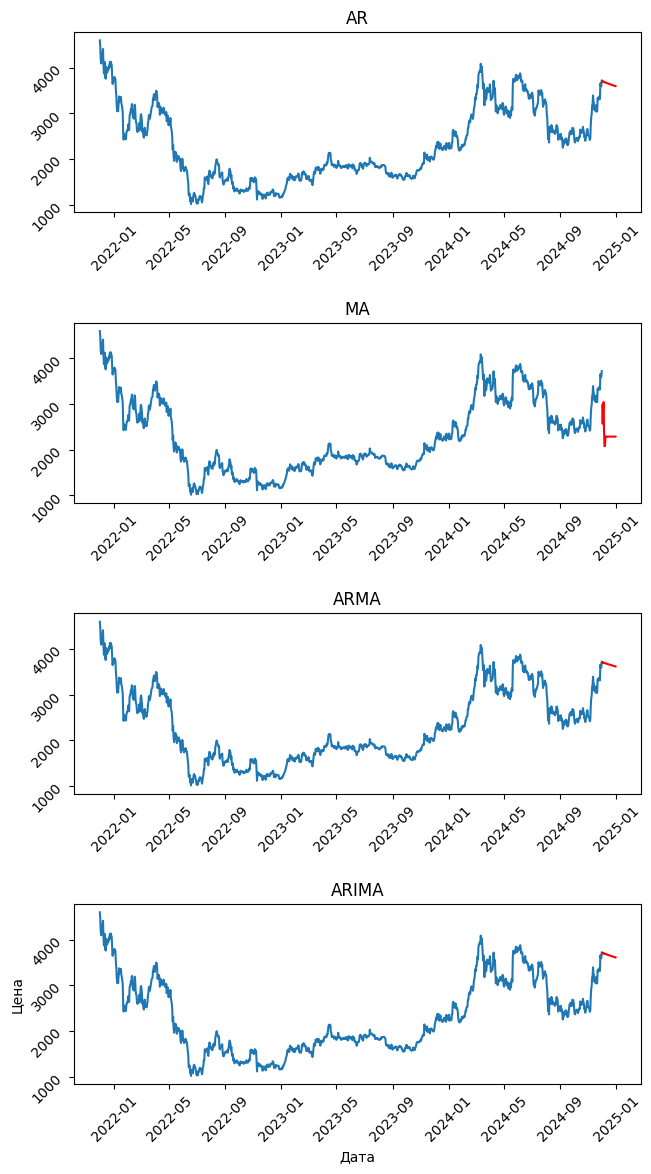

In [17]:
model_ar = ARIMA(deseasonal, order=best_cfg_ar)
model_ma = ARIMA(deseasonal, order=best_cfg_ma)
model_arma = ARIMA(deseasonal, order=best_cfg_arma)
model_arima = ARIMA(deseasonal, order=best_cfg_arima)

model_fit_ar = model_ar.fit()
model_fit_ma = model_ma.fit()
model_fit_arma = model_arma.fit()
model_fit_arima = model_arima.fit()
forecast_ar = model_fit_ar.forecast(steps=30)
forecast_ma = model_fit_ma.forecast(steps=30)
forecast_arma = model_fit_arma.forecast(steps=30)
forecast_arima = model_fit_arima.forecast(steps=30)

fig,ax = plt.subplots(4)
fig.tight_layout()
fig.set_figheight(12)
ax[0].plot(deseasonal.index, deseasonal, label='Исторические данные')
ax[1].plot(deseasonal.index, deseasonal, label='Исторические данные')
ax[2].plot(deseasonal.index, deseasonal, label='Исторические данные')
ax[3].plot(deseasonal.index, deseasonal, label='Исторические данные')
ax[0].plot(forecast_ar.index, forecast_ar, color='red', label='Прогноз')
ax[1].plot(forecast_ma.index, forecast_ma, color='red', label='Прогноз')
ax[2].plot(forecast_arma.index, forecast_arma, color='red', label='Прогноз')
ax[3].plot(forecast_arima.index, forecast_arima, color='red', label='Прогноз')
ax[0].title.set_text("AR")
ax[1].title.set_text("MA")
ax[2].title.set_text("ARMA")
ax[3].title.set_text("ARIMA")
plt.xlabel('Дата')
plt.ylabel('Цена')
ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)
ax[2].tick_params(labelrotation=45)
ax[3].tick_params(labelrotation=45)
plt.show()

In [18]:
ETHUSD_future_30=load_data('ETH-USD','2024-11-01','2024-12-01')

mae_ar = mean_absolute_error(ETHUSD_future_30, forecast_ar)
mae_ma = mean_absolute_error(ETHUSD_future_30, forecast_ma)
mae_arma = mean_absolute_error(ETHUSD_future_30, forecast_arma)
mae_arima = mean_absolute_error(ETHUSD_future_30, forecast_arima)
rmse_ar = np.sqrt(mean_squared_error(ETHUSD_future_30, forecast_ar))
rmse_ma = np.sqrt(mean_squared_error(ETHUSD_future_30, forecast_ma))
rmse_arma = np.sqrt(mean_squared_error(ETHUSD_future_30, forecast_arma))
rmse_arima = np.sqrt(mean_squared_error(ETHUSD_future_30, forecast_arima))
mape_ar = mean_absolute_percentage_error(ETHUSD_future_30,forecast_ar)
mape_ma = mean_absolute_percentage_error(ETHUSD_future_30,forecast_ma)
mape_arma = mean_absolute_percentage_error(ETHUSD_future_30,forecast_arma)
mape_arima = mean_absolute_percentage_error(ETHUSD_future_30,forecast_arima)
print("---AR---")
print(f"MAE: {round(mae_ar,2)}, RMSE: {round(rmse_ar,2)}, MAPE: {round(mape_ar,2)}")
print("---MA---")
print(f"MAE: {round(mae_ma,2)}, RMSE: {round(rmse_ma,2)}, MAPE: {round(mape_ma,2)}")
print("---ARMA---")
print(f"MAE: {round(mae_arma,2)}, RMSE: {round(rmse_arma,2)}, MAPE: {round(mape_arma,2)}")
print("---ARIMA---")
print(f"MAE: {round(mae_arima,2)}, RMSE: {round(rmse_arima,2)}, MAPE: {round(mape_arima,2)}")


[*********************100%***********************]  1 of 1 completed

---AR---
MAE: 544.25, RMSE: 663.19, MAPE: 0.19
---MA---
MAE: 868.61, RMSE: 926.73, MAPE: 0.27
---ARMA---
MAE: 554.34, RMSE: 670.43, MAPE: 0.2
---ARIMA---
MAE: 552.33, RMSE: 669.7, MAPE: 0.2


На основе полученных метрик, можно сказать, что модель ARIMA лучше всего предсказала DOGE-USD. 